In [80]:
from config import *
#from alpaca_trade_api import StreamConn
import websocket, json, asyncio, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller,kpss

<h1> The Strategy: </h1> 
<p> The strategy chooses a high volume mean reverting stock(using ADF and KPSS) from the previous day's quote data and trains an NN to determine the mean price change within the next time step, if the delta change is above threshold, buy/sell accordingly. Trading occurs during specific windows: 9am to 11:00 pm and  1pm to 3pm</p>

<h4> Correction: Trade SPY by default</h4>

<ol> 
    <strong> Logic </strong> 
    <li>loop through high volume stocks list: determine stationarity via ADF and KPSS. Then determine backtested accuracy of NN forecasting mean price change within forecast window (on validation set)   </li>
    <li> during trading hours: monitor and forecast price change with every new incoming quote, if abs(mean price change) > 0.2 ticks, buy/sell with take profit accordingly </li> 
    <li> close any open positions at end of trading session </li> 
    
</ol>

<ul> <strong>  NN Architecture: </strong> 
    <li> hyperparameters:- forecast window: k,lag window L, neurons, LSTM/FC layers (previous n days data (n = 2)  </li> 
    <li> X :-  (m x 3) features: 1. rolling_sum(oi/bid_ask_spread) over lag window, 2. rolling_sum(oir/bid_ask_spread), 3. mpb/bid_ask_spread </li> 
    <li> Y :- (1 x m) forecast price over forecast window </li> 
</ul> 


reference: https://pdfs.semanticscholar.org/cf7e/9d9960be215cbc5a0b9f39d4c50879568be3.pdf

<h2> Formulas: </h2>


Order Imbalance as: 

<img src="images/voi_imbalance.png" width="500"/>

Measure Volume Order imbalance ratio as: 

<img src="images/oir.png" width="200"/>

Develop Linear Model from previous Day's prices with: 
<img src="images/linear_model.png" width="500"/>

mean price basis 
<img src="images/mpb.png" width="500"/>
<img src="images/mpb_explanation.png" width="500"/>

Average Trade Price: 
<img src="images/tp.png" width="500"/>

<p> <strong> Important note: volume is cumulative volume </strong> </p>

default values for linear model: K= 20, L=5 



In [ ]:


def on_open(ws):
    print("stream connection opened")
    auth_data = {
        "action": "auth",
        "params": api_key_id
    }

    ws.send(json.dumps(auth_data))

    channel_data = {
        "action": "subscribe",
        "params": 'Q.SPY'
    }
    ws.send(json.dumps(channel_data))
    
def on_message(ws,data):
    data = json.loads(data)
    for quote in data:
        for key,value in quote.items():
            if key == 't': value = time.strftime('%Y-%m-%d %H:%M:%S.%Z', time.localtime(value/1000))
            print('{}: {} '.format(key,value))
            
def on_close(ws):
    print('closed streaming_connection')

socket = "wss://alpaca.socket.polygon.io/stocks"

ws = websocket.WebSocketApp(socket, on_open=on_open, on_message=on_message, on_close=on_close)
ws.run_forever()

In [ ]:
[{"ev":"Q","sym":"AAPL","c":1,"bx":7,"ax":19,"bp":341.29,"ap":341.33,"bs":1,"as":1,"t":1591899904799,"z":3},
 {"ev":"Q","sym":"AAPL","c":1,"bx":12,"ax":19,"bp":341.28,"ap":341.33,"bs":1,"as":1,"t":1591899904799,"z":3},
 {"ev":"Q","sym":"AAPL","c":1,"bx":19,"ax":19,"bp":341.27,"ap":341.33,"bs":2,"as":1,"t":1591899904799,"z":3},
 {"ev":"Q","sym":"AAPL","c":1,"bx":7,"ax":19,"bp":341.28,"ap":341.33,"bs":1,"as":1,"t":1591899904799,"z":3}]

''' sample quote '''
ev: Q #quote 
sym: SPY #ticker 
c: 1 # idk
bx: 12 # bid exchange 
ax: 11  #ask exchange 
bp: 301.52 #bid price
ap: 301.54 # ask price 
bs: 10 #bid size 
as: 4  #ask size 
t: 2020-06-11 15:01:55 # time to the nearest second 
z: 1 # tape ID 




In [61]:
def turnover_and_mtp_data(asset,date):
    data =  api.polygon.historic_trades_v2(asset, date).df.drop(
    ['participant_timestamp',
    'trf_timestamp',
    'sequence_number',
    'id',
    'exchange',
    'conditions',
    'tape'],
    axis=1).rename(columns = {'size': 'vol'})
    turnover = pd.DataFrame()
    turnover['volume'] = data.vol.resample('1S').sum()
    turnover['price'] = data.price.resample('1S').mean()
    turnover['turnover'] = turnover['price'] * turnover['volume']
    turnover['mtp'] = (turnover['turnover'] - turnover['turnover'].shift(1))/(turnover['volume'] - turnover['volume'].shift(1))
    turnover.loc[turnover['volume'] == turnover['volume'].shift(1),'mtp'] = turnover.loc[turnover['volume'] == turnover['volume'].shift(1),'mtp'].shift(1)
    return turnover


def get_historic_quotes(asset,date):
    df = api.polygon.historic_quotes_v2(asset,date).df.sort_index().drop(
        ['trf_timestamp',
        'sequence_number',
        'conditions',
        'indicators',
        'bid_exchange',
        'ask_exchange',
        'tape',
        'participant_timestamp'], 
        axis = 1)
    #sample_df = df.resample('1min').mean()
    #df.index = df.index.strftime('%m/%d/%Y %H:%M:%S')
    #sample_df.index = sample_df.index.strftime('%m/%d/%Y %H:%M:%S')
    #print(df)
    #print(sample_df)
    resampled = pd.DataFrame()
    resampled['bid_price'] = df.bid_price.resample('1S').mean()
    resampled['bid_size'] = df.bid_size.resample('1S').sum()
    resampled['ask_price'] = df.ask_price.resample('1S').mean()
    resampled['ask_size'] = df.ask_size.resample('1S').sum()
    resampled = resampled.join(turnover_and_mtp_data(asset,date)['mtp'])
    resampled['mtp'].iloc[0] = (resampled['bid_price'].iloc[0] + resampled['ask_price'].iloc[0])/2 # manuallly set mtp at t=0 
    return resampled.dropna()

#spy_1 = get_historic_quotes('SPY','2020-06-11')
#print(spy_1)




def format_training_data(qdf,forecast_window = 20,lag = 5):
    #1. rolling_sum(oi/bid_ask_spread) over lag window, 2. rolling_sum(oir/bid_ask_spread), 3. mpb/bid_ask_spread
    spread = qdf['ask_price'] - qdf['bid_price']
    qdf['dVb'] = qdf['bid_size'].copy()
    qdf.loc[qdf['bid_price'] < qdf['bid_price'].shift(1),'dVb'] = 0
    qdf.loc[qdf['bid_price'] == qdf['bid_price'].shift(1),'dVb'] = qdf['bid_size'] - qdf['bid_size'].shift(1)
    qdf['dVa'] = qdf['ask_size'].copy()
    qdf.loc[qdf['ask_price'] > qdf['ask_price'].shift(1),'dVa'] = 0
    qdf.loc[qdf['ask_price'] == qdf['ask_price'].shift(1),'dVa'] = qdf['ask_size'] - qdf['ask_size'].shift(1)
    imbalance = qdf['dVb'] - qdf['dVa']
    mid_price = (qdf['bid_price'] + qdf['ask_price'])/2
    mean_price_basis = qdf['mtp'] - 0.5*(mid_price.shift(1) + mid_price)
    qdf['mbp'] = mean_price_basis
    qdf['imbalance'] = imbalance
    ir = (qdf['dVb'] - qdf['dVa'])/(qdf['dVb'] + qdf['dVa'])
    qdf['imbalance_over_spread'] = imbalance/spread
    qdf['imbalance_ratio_over_spread'] = ir/spread
    qdf['mpb_over_spread'] = mean_price_basis/spread
    qdf['forecast_mid_price'] = (mid_price.iloc[::-1].rolling(forecast_window).sum() - forecast_window*mid_price)/forecast_window
    return qdf.drop(['dVb','dVa','mtp'],axis = 1) # still have to drop the imbalance and mbp before feeeding to NN
# og_time = df.index[0]
# timestep = 5e4 # 500 milliseconds 
# og_timestamp = og_time.timestamp()*1000
# added_timestamp = og_timestamp 
# added_time = time.strftime('%m/%d/%Y %H:%M:%S',  time.gmtime(added_timestamp/1000.))

#df = api.polygon.historic_quotes_v2('AAPL','2020-06-11')
#print(df[-1])

                            bid_price  bid_size   ask_price  ask_size  \
sip_timestamp                                                           
2020-06-08 04:00:21-04:00  318.962727       108  319.060000        32   
2020-06-08 04:00:24-04:00  318.983333       125  319.087778        47   
2020-06-08 04:01:06-04:00  318.950000         4  319.000000         5   
2020-06-08 04:08:57-04:00  319.130000        28  319.180000        30   
2020-06-08 04:11:00-04:00  319.160000        13  319.200000         5   
...                               ...       ...         ...       ...   
2020-06-08 06:26:32-04:00  320.117500        92  320.169375        89   
2020-06-08 06:38:25-04:00  320.230000        20  320.286000        48   
2020-06-08 06:39:39-04:00  320.411429       110  320.446429        44   
2020-06-08 06:39:45-04:00  320.477059       167  320.522941        70   
2020-06-08 06:39:53-04:00  320.542222        69  320.588889        67   

                                mbp  imbalance  im

/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


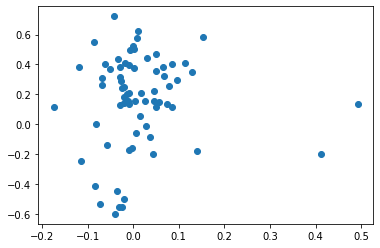

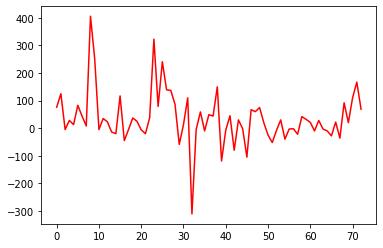

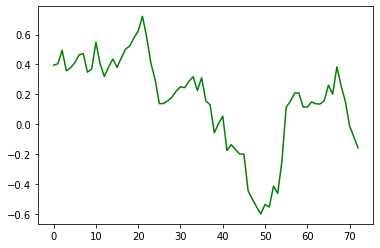

" sample quote \n\nQuote({   'ask_exchange': 12,\n    'ask_price': 347.81,\n    'ask_size': 1,\n    'bid_exchange': 11,\n    'bid_price': 347.74,\n    'bid_size': 2,\n    'conditions': [1],\n    'indicators': [1],\n    'participant_timestamp': 1591883083007479000,\n    'sequence_number': 4543685,\n    'sip_timestamp': 1591883083007660900,\n    'tape': 3})\n    \n    "

In [79]:
df = format_training_data(get_historic_quotes('SPY','2020-06-08')).dropna()

print(df)
plt.figure(0)
plt.scatter(x = df['mbp'],y =df['forecast_mid_price'])
plt.figure(1)
plt.plot(df['imbalance'].tolist(), color = 'red')
plt.figure(2)
plt.plot(df['forecast_mid_price'].tolist(), color ='green')
plt.show()
''' sample quote 

Quote({   'ask_exchange': 12,
    'ask_price': 347.81,
    'ask_size': 1,
    'bid_exchange': 11,
    'bid_price': 347.74,
    'bid_size': 2,
    'conditions': [1],
    'indicators': [1],
    'participant_timestamp': 1591883083007479000,
    'sequence_number': 4543685,
    'sip_timestamp': 1591883083007660900,
    'tape': 3})
    
    '''

In [95]:
voi = df['imbalance'].to_numpy().reshape((-1,1))
mean_price_change = df['forecast_mid_price'].to_numpy().reshape((-1,1))
print('voi adfuller',adfuller(voi))
print('voi kpss',kpss(voi))
print('mpc adfuller',adfuller(mean_price_change))
print('mpc kpss',kpss(mean_price_change))

voi adfuller (-3.3721043062366935, 0.011947398358676269, 2, 70, {'1%': -3.5274258688046647, '5%': -2.903810816326531, '10%': -2.5893204081632653}, 708.7163405711586)
voi kpss (0.30575650503642965, 0.1, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
mpc adfuller (-1.8103177998536266, 0.3753513578454968, 2, 70, {'1%': -3.5274258688046647, '5%': -2.903810816326531, '10%': -2.5893204081632653}, -99.19790644227845)
mpc kpss (0.36791910093965985, 0.09098314614669833, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
